<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/transform_datacube_to_dssat_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Export historical weather and soil data using soil categories

In this workflow, we aim to export combined weather and soil data based on specific soil layer categories, such as soil texture. By aligning both data cubes (weather and soil) to the same projection and spatial resolution, we ensure that the exported data is consistent and ready for analysis. To use this code it is first neccesary to download the weather and soil data; for this example, we have previoulsy downloaded the 2001 weather and soildgrid data for Honduras.

The following example shows how to export weather and soil data for a specific region and the soil texture classification in Honduras. The exported data has a structure compatible to [DSSAT format files](https://dssat.net/wp-content/uploads/2012/02/icasa_lah8_Jww11_gh6.pdf).

#### clone repository

In [ ]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 1580, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1580 (delta 32), reused 58 (delta 23), pack-reused 1499 (from 1)
Receiving objects: 100% (1580/1580), 120.67 MiB | 27.08 MiB/s, done.
Resolving deltas: 100% (1372/1372), done.
Updating files: 100% (436/436), done.


#### install requirements

In [ ]:
!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

In [1]:
import geopandas as gpd
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

#os.chdir('/content/WeatherSoilDataProcessor')


In [2]:
from spatialdata.climate_data import MLTWeatherDataCube
from spatialdata.files_manager import IntervalFolderManager, SoilFolderManager
from spatialdata.gis_functions import get_boundaries_from_path, reproject_xrdata, re_scale_xarray, resample_xarray, add_2dlayer_toxarrayr
from spatialdata.plt_funs import plot_datacube
from spatialdata.soil_data import SoilDataCube, find_soil_textural_class_in_nparray

import numpy as np


## Creating datacubes

First, we will generate two data cubes: one for weather data and another for soil data. The data cubes are multi-dimensional arrays with a four dimensional array. For weather, the dimensions are time, weather variable, latitude and latitude; while for soil, the dimensions are depth, soil property, latitude, and longitud.

In [ ]:
extent = get_boundaries_from_path('data/country.shp', round_numbers = True)

# Specify paths for weather data, such as precipitation and solar radiation
list_weather_paths = {'precipitation': 'weather/precipitation_hnd_raw',
                    'srad': 'weather/solar_radiation_hnd_raw',
                    'tmax': 'weather/temperature_tmax_hnd_raw',
                    'tmin': 'weather/temperature_tmin_hnd_raw'}

starting_date, ending_date = '2001-01-01', '2003-12-31'


wdatacube = MLTWeatherDataCube(list_weather_paths, IntervalFolderManager(), extent=extent)

filenames = wdatacube.common_dates_and_file_names(starting_date=starting_date, ending_date=ending_date)
weather_datacube = wdatacube.multitemporal_data(reference_variable='precipitation', ncores=10)


../weather/precipitation_hnd_raw\1981
../weather/precipitation_hnd_raw\1982
../weather/precipitation_hnd_raw\1983
../weather/precipitation_hnd_raw\1984
../weather/precipitation_hnd_raw\1985
../weather/precipitation_hnd_raw\1986
../weather/precipitation_hnd_raw\1987
../weather/precipitation_hnd_raw\1988
../weather/precipitation_hnd_raw\1989
../weather/precipitation_hnd_raw\1990
../weather/precipitation_hnd_raw\1991
../weather/precipitation_hnd_raw\1992
../weather/precipitation_hnd_raw\1993
../weather/precipitation_hnd_raw\1994
../weather/precipitation_hnd_raw\1995
../weather/precipitation_hnd_raw\1996
../weather/precipitation_hnd_raw\1997
../weather/precipitation_hnd_raw\1998
../weather/precipitation_hnd_raw\1999
../weather/precipitation_hnd_raw\2000
../weather/precipitation_hnd_raw\2001
../weather/precipitation_hnd_raw\2002
../weather/precipitation_hnd_raw\2003
../weather/precipitation_hnd_raw\2004
../weather/precipitation_hnd_raw\2005
../weather/precipitation_hnd_raw\2006
../weather/p

100%|██████████| 15705/15705 [25:30<00:00, 10.26it/s]


In [8]:
import xarray
from datetime import datetime
def create_dimension(xrdata_dict, newdim_name = 'date'):
    weather_datacube_mrs = []
    for k,v in tqdm(xrdata_dict.items()):
        xrtemp = v.expand_dims(dim = [newdim_name])
        xrtemp['date'] = [k]
        weather_datacube_mrs.append(xrtemp)
        
    weather_datacube_mrs = xarray.concat(weather_datacube_mrs, dim = newdim_name)
    weather_datacube_mrs[newdim_name] = [datetime.strptime(i, "%Y%m%d") for i in list(xrdata_dict.keys())]
    return weather_datacube_mrs

weather_datacube_mrs = create_dimension(weather_datacube)

100%|██████████| 15705/15705 [00:15<00:00, 1037.65it/s]


Next, we create the soil data cube

In [9]:
paths = 'soil/hnd'

gfd = gpd.read_file('data/country.shp')
gfd = gfd.to_crs('ESRI:54052')
extent = gfd.total_bounds

folder_manager = SoilFolderManager(paths, ["bdod", "clay",  "sand", "silt","wv0033", "wv1500"])
soilcube = SoilDataCube(folder_manager)
soil_datacube = soilcube.multi_depth_data(verbose=False, reference_variable='sand')

  0%|          | 0/4 [00:00<?, ?it/s]

PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=igh +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"]]
<xarray.Dataset> Size: 17MB
Dimensions:      (x: 2658, y: 1573)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 21kB -9.985e+06 -9.984e+06 ... -9.321e+06 -9.32e+06
  * y            (y) float64 13kB 1.839e+06 1.838e+06 ... 1.446e+06 1.446e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 17MB ...
PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORIT

 25%|██▌       | 1/4 [00:16<00:49, 16.37s/it]

PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=igh +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"]]
<xarray.Dataset> Size: 17MB
Dimensions:      (x: 2658, y: 1573)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 21kB -9.985e+06 -9.984e+06 ... -9.321e+06 -9.32e+06
  * y            (y) float64 13kB 1.839e+06 1.838e+06 ... 1.446e+06 1.446e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 17MB ...
PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORIT

 50%|█████     | 2/4 [00:29<00:29, 14.72s/it]

PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=igh +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"]]
<xarray.Dataset> Size: 17MB
Dimensions:      (x: 2658, y: 1573)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 21kB -9.985e+06 -9.984e+06 ... -9.321e+06 -9.32e+06
  * y            (y) float64 13kB 1.839e+06 1.838e+06 ... 1.446e+06 1.446e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 17MB ...
PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORIT

 75%|███████▌  | 3/4 [00:43<00:14, 14.17s/it]

PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Interrupted_Goode_Homolosine"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=igh +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"]]
<xarray.Dataset> Size: 17MB
Dimensions:      (x: 2658, y: 1573)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 21kB -9.985e+06 -9.984e+06 ... -9.321e+06 -9.32e+06
  * y            (y) float64 13kB 1.839e+06 1.838e+06 ... 1.446e+06 1.446e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 17MB ...
PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORIT

100%|██████████| 4/4 [00:57<00:00, 14.25s/it]


## Reproject to a Common Coordinate Reference System (CRS)

Both weather and soil data must have the same projection to ensure spatial alignment. Here, we reproject the soil data to match the weather data in the common CRS (Coordinate Reference System), for this example will be WGS84 (epsg:4326).

In [10]:
crs = 'ESRI:54052'
#crs = 'EPSG:4326'
weather_datacube_mrs= weather_datacube_mrs.rio.write_crs('EPSG:4326').rio.reproject(crs)
soil_datacube = {k: reproject_xrdata(v,target_crs=crs) for k, v in soil_datacube.items()}

PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
<xarray.Dataset> Size: 184MB
Dimensions:  (y: 1574, x: 2659)
Coordinates:
  * x        (x) float64 21kB -9.985e+06 -9.984e+06 ... -9.32e+06 -9.32e+06
  * y        (y) float64 13kB 1.839e+06 1.838e+06 ... 1.446e+06 1.445e+06
Data variables:
    sand     (y, x) float32 17MB 332.0 339.0 341.0 343.0 ... nan nan nan nan
    bdod     (y, x) float64 33MB 110.0 111.0 112.0 111.0 ... nan nan nan nan
    clay     (y, x) float64 33MB 376.0 367.0 348.0 349.0 ... nan nan nan nan
    silt     (y, x) float64 33MB 292.0 294.0 311.0 308.0 ... nan nan nan nan
    wv0033   (y, x) float64 33MB 326.0 323.5 319.5 317.3 ... nan nan nan nan
    wv1500   (y, x) float6

## Extracting data for a specific region

In this part of the analysis, we focus on extracting weather and soil data for a specific location—typically at the level of an administrative division, such as a district or municipality. By focusing on a specific region, we can obtain more detailed and relevant insights, particularly in terms of climate and soil characteristics that may impact agriculture, agronomic management, or other land-use practices.

### Selection of the region of interest (ROI)
We begin by defining the boundary for the specific location, often using geographic data from administrative boundary shapefiles.

In [11]:
gdf = gpd.read_file('data/tb_limitealdeas.shp')
gdf.to_crs(crs, inplace= True)
locality = 'Río Plátano'
subset = gdf.loc[gdf['ALDEA'] == locality]
subset

,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
59,090212,Río Plátano,090212,0902,09,265.946,4.45578,Brus Laguna,Gracias a Dios,26594.643479,"POLYGON ((-9499976.554 1768074.171, -9498931.6..."


### Masking Data to the ROI:
Once the region is defined, the weather and soil data are "masked," meaning that the data cubes are filtered to only include values within the selected boundaries.

In [ ]:
from spatialdata.gis_functions import mask_xarray_using_rio
soil_datacube_subset = soilcube.mask_mldata(soil_datacube.copy(),subset.geometry)
weather_datacube_subset = mask_xarray_using_rio(weather_datacube_mrs.copy(), subset.geometry)

weather_datacube_subset = weather_datacube_subset.where(weather_datacube_subset<1.79769313e+307, np.nan)

100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


### Combining Weather and Soil Data
#### Rescale Soil and Weather Data Cubes

Since weather data and soil data might have different spatial resolutions, we need to rescale them so that they can be stacked and analyzed together. This step ensures that both datasets align perfectly.
We first rescale the weather data and then use this rescaled version as a reference for adjusting the soil data resolution.
- **Weather Rescaling:** The weather data cube is upscaling using a scale factor. The method employed for downscaling is nearest neighbor resampling, which assigns the nearest pixel value to the new grid cells. This is an efficient approach that preserves the original data patterns and avoids interpolation approaches.
- **Soil Rescaling:** After upscaling the weather data, we use it as a reference to rescale the soil data. In this case, the soil data is downscaled to match the resolution of the rescaled weather data. The same nearest neighbor resampling method is applied, ensuring the soil data aligns spatially with the weather data.

In [29]:

scale_factor = 10 ## factor for dowsampling

# weaather rescale
weather_datacube_subsetr = re_scale_xarray(weather_datacube_subset, scale_factor= scale_factor)
# soil rescale
xr_reference = weather_datacube_subsetr.isel(date = 1)

soil_datacube_r = {}
for k,v in tqdm(soil_datacube_subset.items()):
    soil_datacube_r[k] = resample_xarray(v, xrreference=xr_reference)

100%|██████████| 4/4 [00:00<00:00, 18.32it/s]


Text(0.5, 1.0, 'solar radiation rescaled')

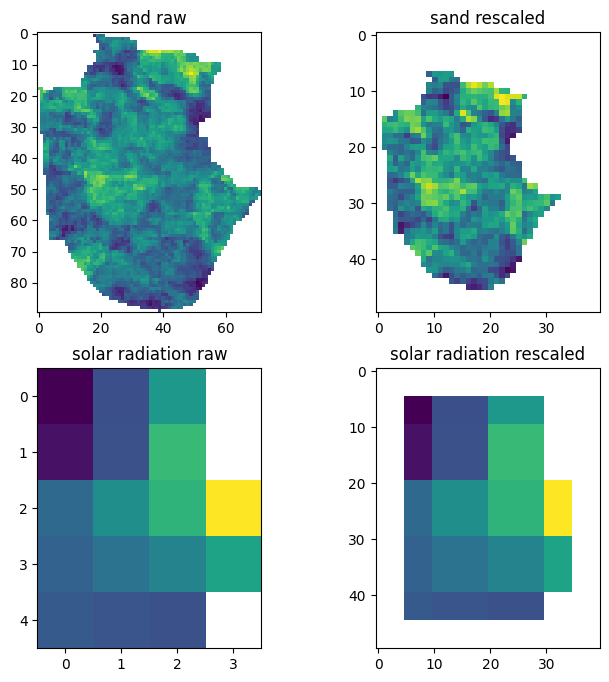

In [30]:
## plots
f, ax = plt.subplots(nrows = 2, ncols= 2, figsize = (8,8))


ax[0,0].imshow(soil_datacube_subset['0-5'].clay.values)
ax[0,0].set_title('sand raw')
ax[0,1].imshow(soil_datacube_r['0-5'].clay.values)
ax[0,1].set_title('sand rescaled')

ax[1,0].imshow(weather_datacube_subset.isel(date = 10).srad.values)
ax[1,0].set_title('solar radiation raw')
ax[1,1].imshow(weather_datacube_subsetr.isel(date = 10).srad.values)
ax[1,1].set_title('solar radiation rescaled')

### Summarizing the weather and soil data using a category
#### Soil texture classification

Soil texture is based on the percentage of sand, clay, and silt.  Soil texture plays a significant role in agriculture, influencing water retention, nutrient availability, and crop suitability.
In this step, we will integrate soil texture classification into our datacube. This allows us to summarize the weather and soil conditions according to different soil texture classes, providing insights that are highly relevant for crop planning and land management

In [31]:
#### Adding Texture to the Data Cube:

soil_datacube_rmrt = {}

for k,v in soil_datacube_r.items():

    sand = v.sand.values*0.1 if np.nanmax(v.sand.values) > 300 else v.sand.values
    clay = v.clay.values*0.1 if np.nanmax(v.clay.values) > 300 else v.clay.values

    texturemap = find_soil_textural_class_in_nparray(sand, clay).astype(float)
    texturemap[texturemap == 0] = np.nan

    soil_datacube_rmrt[k] = add_2dlayer_toxarrayr(texturemap, v, variable_name='texture')

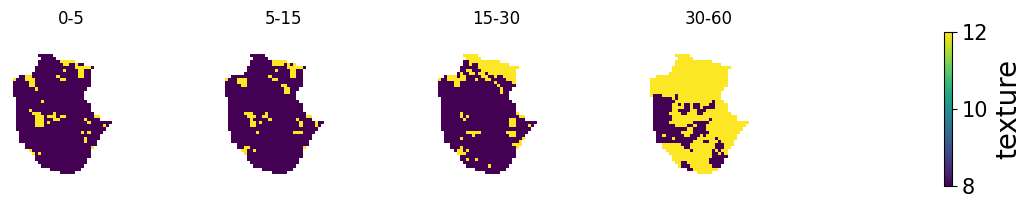

In [32]:
f,a = plot_datacube(soil_datacube_rmrt,dates=False, variable='texture', limit= 4, ncols=4, nrows=1, figsize = (15,2), invertaxis = False, label_name ='texture', legfontsize = 20, fontname= 'sans' )

#### Summarizing Data by Soil Texture:
we summarize the weather data for each soil texture category. This step helps to understand how different soil types respond to weather conditions over time.

In [33]:
from spatialdata.soil_data import TEXTURE_CLASSES
import xarray
from datetime import datetime
soilref = soil_datacube_rmrt['0-5']
weatherdatavars = list(weather_datacube_subsetr.data_vars.keys())
weather_datacube_mrs = xarray.merge([weather_datacube_subsetr,soilref])[weatherdatavars+ ['texture']]

#### Exporting weather data per texture as CSV and DSSAT format files
Once we've combined and summarized the weather and soil data by texture categories, the next step is to export this data for further analysis. We can export the weather data for each soil texture both as CSV files and in DSSAT format, which is widely used in agricultural modeling.

In [35]:
from spatialdata.soil_data import TEXTURE_CLASSES
from crop_modeling.utils import from_weather_to_dssat, check_weatherxr_scales, DSSATSoil_fromSOILGRIDS
from crop_modeling.utils import from_soil_to_dssat, get_variables_to_summarize

import copy


In [36]:
if os.path.exists('tmp'):
    !rm -r tmp
!mkdir tmp

params_df_names = {
    "DATE": "date",
    "TMIN": "tmin",
    "SRAD": "srad",
    "RAIN": "precipitation",
    "TMAX": "tmax",
    "LON": "x",
    "LAT": "y"
}

from_weather_to_dssat(copy.deepcopy(weather_datacube_mrs), date_name = 'date', groupby = 'texture', params_df_names=params_df_names,outputpath='tmp', outputfn = 'WHTEL1', codes=TEXTURE_CLASSES)


15705it [01:47, 145.80it/s]


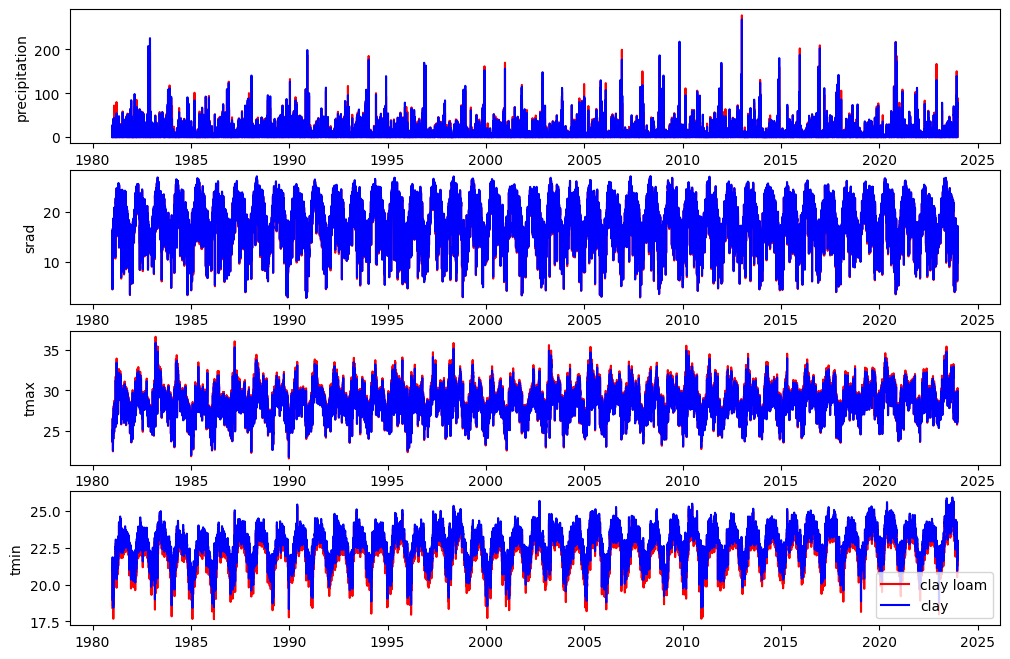

In [37]:

vars_metric = {}

for i in weather_datacube_mrs.data_vars.keys():
    vars_metric.update({i: 'mean'})
vars_metric.pop('texture')


df = check_weatherxr_scales(weather_datacube_mrs).to_dataframe().dropna().reset_index().groupby(['texture','date']).agg(vars_metric).reset_index()

s={8:'r',12:'b'}
f, a =plt.subplots(nrows = 4,ncols = 1, figsize = (12,8))
for idx,grp in df.groupby(['texture']):
    for i,var in enumerate(vars_metric.keys()):
        a[i].plot(grp.date.values, grp[var].values, c=s[int(grp['texture'].values[0])], label = TEXTURE_CLASSES[int(grp['texture'].values[0])])
        a[i].set_ylabel(var)
plt.legend()

In [ ]:
### export as nc
weather_datacube_mrs.to_netcdf('tmp/weather.nc')

In [ ]:
### export as csv
df.to_csv('tmp/weather.csv')

#### Exporting soil data per texture as CSV and DSSAT format files

In addition to weather data, soil data can also be exported for further analysis.


In [38]:


soil_datacube_mrs = []
for ks, vs in soil_datacube_rmrt.items():
    xrtemp = vs.expand_dims(dim = ['depth'])
    xrtemp['depth'] = [ks]
    soil_datacube_mrs.append(xrtemp)

soil_datacube_mrs = xarray.concat(soil_datacube_mrs, dim = 'depth')
soil_datacube_mrs['depth'] = [i.split('-')[1] for i in soil_datacube_mrs['depth'].values]
soil_datacube_mrs['depth'] = soil_datacube_mrs['depth'].astype(int)
soil_datacube_mrs = soil_datacube_mrs.sortby('depth')

In [39]:
soil_df = from_soil_to_dssat(soil_datacube_mrs, groupby='texture', outputpath='tmp', outputfn='SOILL1', codes=TEXTURE_CLASSES)


sand 29.608998554853653 clay 37.54416539575164
sand 27.366604480557324 clay 40.73820420411644


In [40]:
DSSATSoil_fromSOILGRIDS.GENERAL_DESCRIPTION

{'SLLL': 'Lower limit of plant extractable soil water, cm3 cm-3',
 'SDUL': 'Drained upper limit, cm3 cm-3',
 'SSAT': 'Upper limit, saturated, cm3 cm-3',
 'SRGF': 'Root growth factor, soil only, 0.0 to 1.0',
 'SBDM': 'Bulk density, moist, g cm-3',
 'SLOC': 'Organic carbon, %',
 'SLCL': 'Clay (<0.002 mm), %',
 'SLSI': 'Silt (0.05 to 0.002 mm), %',
 'SLCF': 'Coarse fraction (>2 mm), %',
 'SLNI': 'Total nitrogen, %',
 'SLHW': 'Soil pH',
 'SMHB': 'pH in buffer determination method, code',
 'SCEC': 'Cation exchange capacity, cmol kg-1',
 'SADC': 'Anion adsorption coefficient, cm3 (H2O) g [soil]-1',
 'SSKS': 'Saturated hydraulic conductivity, macropore, cm h-1'}

In [41]:
soil_df.to_csv('tmp/soil.csv')